# Configurando o código

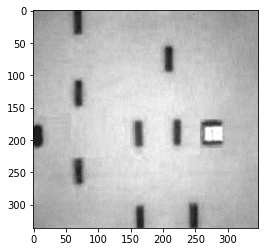

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
from collections import namedtuple
import math
import queue

from matplotlib import pyplot as plt
%matplotlib inline

IMAGE = './Cenario.jpg'
Point = namedtuple('Point', ['x', 'y'])

plt.gray()

def showImg(img):
  plt.imshow(img)
  plt.show()

# read image
img = cv.imread(IMAGE, cv.IMREAD_COLOR)
# transform to gray
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_width, img_height = img.shape;

plt.imshow(img)
plt.show()

# Realizando o mapeamento em cima da imagem

## Encontrando o robô

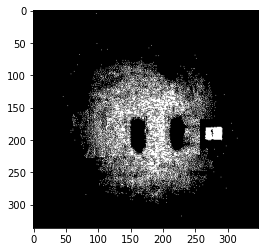

In [2]:
# transform image to binary
(T, treshold_robot) = cv.threshold(img, 220, 255, cv.THRESH_BINARY)
showImg(treshold_robot)

Abertura

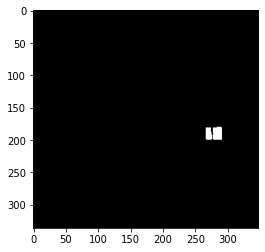

In [3]:
kernel = np.ones((7,7),np.uint8)
opening_robot = cv.morphologyEx(treshold_robot, cv.MORPH_OPEN, kernel)
showImg(opening_robot)

Fechamento

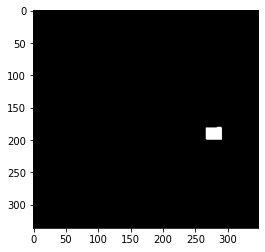

In [4]:
kernel = np.ones((5,5),np.uint8)
closing_robot = cv.morphologyEx(opening_robot, cv.MORPH_CLOSE, kernel)
showImg(closing_robot)

Encontrando o contorno

In [0]:
contours, _ = cv.findContours(closing_robot, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
robot_contour = contours[0]

Criando a bounding box

In [0]:
ROBOT_BOUNDING_TOLERANCE = 10;

robot = cv.boundingRect(robot_contour)
robot_min_x, robot_min_y, robot_width, robot_height = robot
robot_min_x = robot_min_x - ROBOT_BOUNDING_TOLERANCE;
robot_min_y = robot_min_y - ROBOT_BOUNDING_TOLERANCE;
robot_width = robot_width + (ROBOT_BOUNDING_TOLERANCE * 2);
robot_height = robot_height + (ROBOT_BOUNDING_TOLERANCE * 2);

robot_max_x = robot_min_x + robot_width;
robot_max_y = robot_min_y + robot_height;

robot_bounding_box = np.array([
    [[robot_min_x, robot_min_y]], 
    [[robot_max_x, robot_min_y]],
    [[robot_max_x, robot_max_y]],
    [[robot_min_x, robot_max_y]]]);

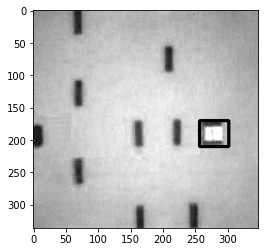

In [7]:
robot_preview = img.copy();
cv.drawContours(robot_preview, [robot_bounding_box], -1, (0,255,0), 3)
showImg(robot_preview)

## Encontrando os obstáculos

Eliminando o robô

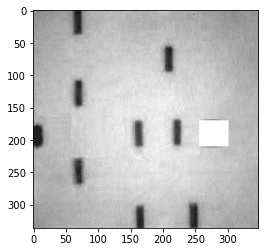

In [8]:
obstacle_img = img.copy()
obstacle_img[robot_min_y:robot_max_y, robot_min_x:robot_max_x] = 255;
showImg(obstacle_img);

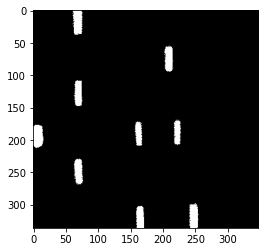

In [9]:
# transform image to binary
(T, treshold_obstacle) = cv.threshold(obstacle_img, 100, 255, cv.THRESH_BINARY_INV)
showImg(treshold_obstacle)

Realizando abertura para tirar imperfeições dos obstáculos

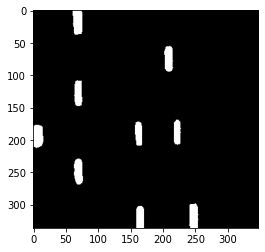

In [10]:
kernel = np.ones((5, 5),np.uint8)
closing_obstacle = cv.morphologyEx(treshold_obstacle, cv.MORPH_CLOSE, kernel)
showImg(closing_obstacle)

Encontrando contornos

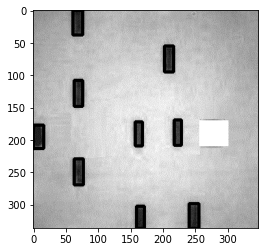

In [11]:
def contour_to_bounding_box(contour):
  boundingBox = cv.boundingRect(contour)
  min_x, min_y, width, height = boundingBox

  max_x = min_x + width;
  max_y = min_y + height;

  return np.array([
      [[min_x, min_y]], 
      [[max_x, min_y]],
      [[max_x, max_y]],
      [[min_x, max_y]]]);

obstacles_bounding_boxes, _ = cv.findContours(closing_obstacle, cv.RETR_TREE, cv.CHAIN_APPROX_NONE);
for i in range(len(obstacles_bounding_boxes)):
  obstacles_bounding_boxes[i] = contour_to_bounding_box(obstacles_bounding_boxes[i])

cv.drawContours(obstacle_img, obstacles_bounding_boxes, -1, (0,255,0), 3);

showImg(obstacle_img);

Método de verificação se uma célula está tendo intersecção com uma bounding box

In [0]:
def get_x_and_y(points):
  return (
    [point[0][0] for point in points],
    [point[0][1] for point in points],
  );

def is_intersection(vector_1, vector_2):
  all_points_higher = all(all(point_1 >= point_2 for point_2 in vector_2) for point_1 in vector_1);
  all_points_lower = all(all(point_1 <= point_2 for point_2 in vector_2) for point_1 in vector_1);
  return not (all_points_higher or all_points_lower);

def intersect_bounding_box(grid, bounding_boxes):
  for bounding_box in bounding_boxes:
    grid_x, grid_y = get_x_and_y(grid);
    box_x, box_y = get_x_and_y(bounding_box);
    if is_intersection(grid_x, box_x) and is_intersection(grid_y, box_y):
      return True;
  return False;

In [0]:
GRID_SIZE = 10;

def point_to_grid(x, y):
  min_x = x * GRID_SIZE;
  min_y = y * GRID_SIZE;
  max_x = min_x + GRID_SIZE;
  max_y = min_y + GRID_SIZE;

  return (np.array([
      [[min_x, min_y]],
      [[max_x, min_y]],
      [[min_x, max_y]],
      [[max_x, max_y]]
    ]),
    min_x,
    min_y,
    max_x,
    max_y
  );

Criando a matriz do mundo

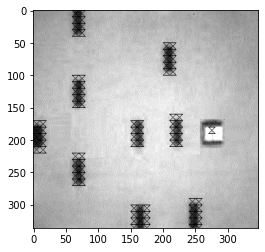

In [14]:
OBSTACLE = -33333

objects_img = img.copy();
height, width = objects_img.shape;
rows = math.ceil(height / GRID_SIZE);
columns = math.ceil(width / GRID_SIZE);

MAP = [[0 for _ in range(columns)] for __ in range(rows)];

robot_center_x = round(robot_min_x + robot_width/2);
robot_center_y = round(robot_min_y + robot_height/2);

robot_cell_defined = False;
for x in range(rows):
  for y in range(columns): 
    grid, grid_min_x, grid_min_y, grid_max_x, grid_max_y = point_to_grid(x, y);

    is_robot_inside_cell = (
        grid_min_x <= robot_center_x 
        and grid_max_x >= robot_center_x
        and grid_min_y <= robot_center_y 
        and grid_max_y >= robot_center_y
    );
    if not robot_cell_defined and is_robot_inside_cell:
      # Definindo a célula de início
      START = Point(x, y)
      cv.polylines(objects_img, [grid], True, (0, 0, 0));
      robot_cell_defined = True;
    elif intersect_bounding_box(grid, obstacles_bounding_boxes):
      # Definindo os obstáculos
      MAP[x][y] = OBSTACLE;
      cv.polylines(objects_img, [grid], True, (0, 255, 255));

showImg(objects_img);

# Encontrando o caminho

In [0]:
GOAL = Point(5, 2)

Função que define os vizinhos

In [0]:
def change_neighbor(X, Y):
    num = MAP[X][Y] + 1

    try:
        #up
        if(X > 0 and MAP[X-1][Y] == 0):
            MAP[X-1][Y] = num
    except:
        pass

    try:
        #right
        if(MAP[X][Y+1] == 0):
            MAP[X][Y+1] = num
    except:
        pass

    try:
        #down 
        if(MAP[X+1][Y] == 0):
            MAP[X+1][Y] = num
    except:
        pass

    try:
        #left
        if(Y > 0 and MAP[X][Y-1] == 0):
            MAP[X][Y-1] = num
    except:
        pass

Função que alimenta os vizinhos

In [0]:
def add_neighbor(queue, X, Y):
    try:
        #up
        if(X > 0 and MAP[X-1][Y] == 0):
            queue.put(Point(X-1, Y))
    except:
        pass

    try:
        #right
        if(MAP[X][Y+1] == 0):
            queue.put(Point(X, Y+1))
    except:
        pass

    try:
        #down 
        if(MAP[X+1][Y] == 0):
            queue.put(Point(X+1, Y))
    except:
        pass

    try:
        #left
        if(Y > 0 and MAP[X][Y-1] == 0):
            queue.put(Point(X, Y-1))
    except:
        pass

Função que encontra o menor vizinho

In [0]:
def find_smaller_neighbor(X, Y):
    smaller_point = None
    smaller_value = 99999
    try:
        #up
        if(X > 0 and MAP[X-1][Y] > 0):
            smaller_value = smaller_value if smaller_value < MAP[X-1][Y] else MAP[X-1][Y]
            smaller_point = smaller_point if smaller_value < MAP[X-1][Y] else Point(X-1, Y) 
    except:
        pass

    try:
        #right
        if(MAP[X][Y+1] > 0):
            smaller_value = smaller_value if smaller_value < MAP[X][Y+1] else MAP[X][Y+1]
            smaller_point = smaller_point if smaller_value < MAP[X][Y+1] else Point(X, Y+1) 
    except:
        pass

    try:
        #down
        if(MAP[X+1][Y] > 0):
            smaller_value = smaller_value if smaller_value < MAP[X+1][Y] else MAP[X+1][Y]
            smaller_point = smaller_point if smaller_value < MAP[X+1][Y] else Point(X+1, Y) 
    except:
        pass

    try:
        #left
        if(Y > 0 and MAP[X][Y-1] > 0):
            smaller_value = smaller_value if smaller_value < MAP[X][Y-1] else MAP[X][Y-1]
            smaller_point = smaller_point if smaller_value < MAP[X][Y-1] else Point(X, Y-1) 
    except:
        pass

    return smaller_point

In [0]:
def printMap():
    print(np.matrix(MAP))
    print("")
    print("")

Executando o WaveFront

In [20]:
def execute_wavefront():
    fila = queue.Queue()
    MAP[GOAL.x][GOAL.y] = 1
    fila.put(GOAL)
    while not fila.empty():
        current_point = fila.get()
        add_neighbor(fila, current_point.x, current_point.y)
        change_neighbor(current_point.x, current_point.y)


execute_wavefront()
printMap()

[[ 8  7  6 ... 36 37 38]
 [ 7  6  5 ... 35 36 37]
 [ 6  5  4 ... 34 35 36]
 ...
 [33 32 31 ... 57 58 59]
 [34 33 32 ... 58 59 60]
 [35 34 33 ... 59 60 61]]




Encontrando o menor caminho

In [21]:
def find_path(start_point, goal_point):
    if(start_point is None):
        print("Start point not found")
        return None
    
    visited = []
    visited.append(start_point)
    while goal_point not in visited:
        point = visited[-1]
        smaller = find_smaller_neighbor(point.x, point.y)
        visited.append(smaller)

    return visited

path = find_path(START, GOAL)
print(path)

[Point(x=27, y=18), Point(x=27, y=17), Point(x=27, y=16), Point(x=27, y=15), Point(x=27, y=14), Point(x=27, y=13), Point(x=27, y=12), Point(x=27, y=11), Point(x=27, y=10), Point(x=27, y=9), Point(x=27, y=8), Point(x=27, y=7), Point(x=27, y=6), Point(x=27, y=5), Point(x=27, y=4), Point(x=26, y=4), Point(x=25, y=4), Point(x=24, y=4), Point(x=23, y=4), Point(x=22, y=4), Point(x=21, y=4), Point(x=20, y=4), Point(x=19, y=4), Point(x=18, y=4), Point(x=17, y=4), Point(x=16, y=4), Point(x=15, y=4), Point(x=14, y=4), Point(x=13, y=4), Point(x=12, y=4), Point(x=11, y=4), Point(x=10, y=4), Point(x=9, y=4), Point(x=8, y=4), Point(x=7, y=4), Point(x=6, y=4), Point(x=5, y=4), Point(x=5, y=3), Point(x=5, y=2)]


Desenhando o menor caminho

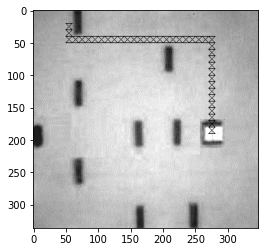

In [22]:
for point in path:
  point_grid, _, _, _, _ = point_to_grid(point.x, point.y)
  cv.polylines(img, [point_grid], True, (0, 0, 0));

showImg(img);